

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Taxi**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the taxi problem (see [Taxi documentation](https://gymnasium.farama.org/environments/toy_text/taxi/)).


Autores:

Sergio Arroni del Riego (s.arroni@alumnos.upm.es)

David González Fernández (david.gonzalezf@alumnos.upm.es)

José Manuel Lamas Pérez (jm.lperez@alumnos.upm.es)

## Imports

In [2]:
# @title Imports
import os
import time
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.nn.functional import smooth_l1_loss as huber_loss
from tensorflow import keras
from itertools import count
from pathlib import Path
from os import system
from collections import namedtuple
from tqdm import trange
from IPython.display import clear_output

## Hyperparameters

In [3]:
# @title Hyperparameters
GAMMA = 0.99
MEMORY_SIZE = 50000
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.001
EXPLORATION_DECAY = 400
NUMBER_OF_EPISODES_FOR_TRAINING = 3000
NUMBER_OF_EPISODES_FOR_TESTING = 30
TARGET_MODEL_UPDATE_EPISODES = 20
MAX_STEPS_PER_EPISODE = 100

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

## Class ReplayMemory

Memory of transitions for experience replay.

# Cambios en la Implementación de la Memoria de Reproducción (Replay Memory)

En la implementación original, la memoria de reproducción (`ReplayMemory`) estaba basada en matrices NumPy para almacenar las transiciones del agente. Se utilizaban múltiples matrices independientes para almacenar estados, acciones, recompensas, estados siguientes y estados terminales. A continuación, se describen los cambios realizados y sus justificaciones:

## Uso de la Tupla con nombre `Transition`
Se introdujo una tupla con nombre llamada `Transition` para representar una transición del entorno. Esta tupla incluye campos para el estado actual, la acción tomada, el siguiente estado, la recompensa obtenida y un indicador booleano para indicar si el estado siguiente es un estado terminal. El uso de la tupla con nombre hace que el código sea más legible y reduce la posibilidad de errores al acceder a los elementos de la transición.

```python
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))
```

## Cambio en el Almacenamiento de Transiciones
En lugar de mantener varias matrices independientes, se utiliza una lista única llamada `memory` para almacenar las transiciones como instancias de la tupla `Transition`. Esta lista se inicializa vacía y se va llenando a medida que se almacenan nuevas transiciones. Cuando la capacidad máxima se alcanza, las nuevas transiciones reemplazan a las más antiguas en un ciclo circular, lo que mantiene la memoria limitada al tamaño especificado.

```python
def push(self, *args):
    """Saves a transition."""
    if len(self.memory) < self.capacity:
        self.memory.append(None)
    self.memory[self.position] = Transition(*args)
    self.position = (self.position + 1) % self.capacity
```

## Muestreo Eficiente
La función `sample_memory` fue reemplazada por `sample`, que utiliza una generación eficiente de índices aleatorios mediante `numpy.random.default_rng()`. Esto mejora la eficiencia y la velocidad del muestreo de la memoria de reproducción.

```python
def sample(self, batch_size):
    idx = self.rng.choice(np.arange(len(self.memory)), batch_size, replace=False)
    res = [self.memory[i] for i in idx]
    return res
```

## Métodos Adicionales
Se añadió el método `__len__` para obtener la longitud actual de la memoria de reproducción, lo que facilita realizar un seguimiento del tamaño actual.

```python
def __len__(self):
    return len(self.memory)
```

Estos cambios buscan mejorar la claridad del código, la eficiencia y la facilidad de mantenimiento al adoptar mejores prácticas de Python y estructuras de datos más adecuadas. La implementación resultante es más legible y fácil de entender.

In [5]:

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.rng = np.random.default_rng()

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        idx = self.rng.choice(np.arange(len(self.memory)), batch_size, replace=False)
        res = []
        for i in idx:
            res.append(self.memory[i])
        return res

    def __len__(self):
        return len(self.memory)

## Class DQN 

La clase DQN se ha separado en dos: DQN y QAgent para que el código esté más organizado y se entienda mejor.

La clase DQN contiene la implementación de la arquitectura utilizada. En `__init__` se definen las capas mientras que en la función `forward` se introducen las funciones de activación.

## Class QAgent

El constructor `__init__` del agente Q realiza la inicialización del objeto, configurando parámetros clave. Algunas de las configuraciones notables incluyen:

Entorno (env): Se crea un entorno de Taxi con la biblioteca Gym.
Modelo DQN (model_class): Se define la clase del modelo como DQN.
Dispositivo de Ejecución (device): Se selecciona automáticamente el dispositivo GPU si está disponible; de lo contrario, se utiliza la CPU.
Memoria de Reproducción (memory): Se inicializa como None y se asignará más adelante durante el entrenamiento.
Directorio de Respaldo del Modelo (model_dir): Se establece un directorio para almacenar respaldos del modelo.
Comprobación de Modelo Preentrenado (pt_path): Determina si se reanuda desde un modelo preentrenado o se inicia uno nuevo.

## Compile

El método `compile` compila el modelo DQN, inicializando el modelo y el optimizador. Algunas características destacadas son:

Inicialización del Modelo (self.model): Se inicializa con la clase DQN y se carga un modelo preentrenado si está disponible.
Inicialización del Modelo Objetivo (self.target_model): Se inicializa como una copia del modelo actual y se configura en modo de evaluación.
Optimizador Adam (self.optimizer): Se inicializa con una tasa de aprendizaje específica.

## Funciones Epsilon-Greedy

Estas funciones implementan la política epsilon-greedy. `_get_epsilon` calcula el valor de epsilon basado en el número de episodios, mientras que `_choose_action` selecciona una acción según la política epsilon-greedy.

## Entrenamiento del modelo

La función `train_model` entrena el modelo DQN utilizando una muestra de la memoria de reproducción. Incluye pasos para calcular los valores Q predichos y esperados, calcular la pérdida y optimizar el modelo.

## Update target

Esta función actualiza la red objetivo copiando los pesos del modelo actual. Se realiza periódicamente para estabilizar el aprendizaje.

## Remember

Este método almacena una transición en la memoria de reproducción, encapsulando el estado, la acción, el próximo estado, la recompensa y una bandera de finalización.

## Fit

Este método implementa el ciclo de entrenamiento del agente Q, manejando interrupciones y mostrando el progreso del entrenamiento. Incluye pasos para la inicialización del entorno, selección de acciones, entrenamiento del modelo, actualización de la red objetivo y visualización del progreso.

## Plot durations

Este método genera gráficos para visualizar la duración de los episodios, las recompensas y los valores de epsilon a lo largo del entrenamiento.

## Save

Este método guarda el estado actual del modelo y del optimizador en un archivo de punto de control.

## Moving Average

Esta función calcula el promedio móvil de una secuencia para suavizar las curvas de los gráficos.


In [6]:
# @title DQN
class DQN(nn.Module):
    def __init__(self, number_of_observations, number_of_actions):
        super(DQN, self).__init__()
        self.emb = nn.Embedding(number_of_observations, 6)
        self.l1 = nn.Linear(6, 50)
        self.l2 = nn.Linear(50, 50)
        self.l3 = nn.Linear(50, 50)
        self.l4 = nn.Linear(50, 100)  
        self.l5 = nn.Linear(100, number_of_actions)

    def forward(self, x):
        x = F.relu(self.l1(self.emb(x)))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))  
        x = self.l5(x)
        return x

In [7]:
# @title QAgent
class QAgent:
    def __init__(self, pt_path: str = None) -> None:
        """
        Initializes a QAgent object.

        Args:
            pt_path (str, optional): Path to a pre-trained model. Defaults to None.
        """
        # Initialize QAgent object with optional pre-trained model path
        self.env = gym.make("Taxi-v3").env
        self.model_dir = Path("./model_backup")
        self.model_class = DQN
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory = None
        self.rng = np.random.default_rng(42)
        self.episode_durations = []
        self.reward_in_episode = []
        self.epsilon_vec = []
        self.last_step = 0
        self.last_episode = 0

        # Create model backup directory if it doesn't exist
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)

        # Determine if resuming from a pre-trained model
        self.is_resume = True if pt_path else False
        self.pt_path = (
            pt_path
            if self.is_resume
            else f"{self.model_dir}/pytorch_{int(time.time())}.pt"
        )
        self.checkpoint = torch.load(self.pt_path) if self.is_resume else None

        # training
        self.batch_size: int = BATCH_SIZE
        self.learning_rate: float = LEARNING_RATE
        self.loss = huber_loss
        self.num_episodes: int = NUMBER_OF_EPISODES_FOR_TRAINING
        self.train_steps: int = 1000000
        self.warmup_episode: int = 0 if self.is_resume else 100
        self.save_freq: int = 1000
        # optimizer
        self.lr_min: float = 0.0001
        self.lr_decay: int = 5000
        # rl
        self.gamma: float = GAMMA
        self.max_steps_per_episode: int = MAX_STEPS_PER_EPISODE
        self.target_model_update_episodes: int = TARGET_MODEL_UPDATE_EPISODES
        self.max_queue_length: int = MEMORY_SIZE
        # epsilon
        self.max_epsilon: float = EXPLORATION_MAX
        self.min_epsilon: float = EXPLORATION_MIN
        self.decay_epsilon: float = EXPLORATION_DECAY

    def compile(self) -> None:
        """
        Compiles the DQN model by initializing the model, loading the checkpoint if resume is enabled,
        initializing the target model, setting it to evaluation mode, and initializing the optimizer.
        """
        n_actions = self.env.action_space.n
        number_of_observations = self.env.observation_space.n

        self.model = self.model_class(number_of_observations, n_actions).to(self.device)
        if self.is_resume:
            self.model.load_state_dict(self.checkpoint["model_state_dict"])
        self.target_model = self.model_class(number_of_observations, n_actions).to(
            self.device
        )
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        if self.is_resume:
            self.optimizer.load_state_dict(self.checkpoint["optimizer_state_dict"])

    def _get_epsilon(self, episode: int) -> float:
        """
        Compute epsilon for epsilon-greedy policy.

        Args:
            episode (int): The current episode number.

        Returns:
            float: The computed epsilon value.
        """
        return self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(
            -episode / self.decay_epsilon
        )

    def _get_action_for_state(self, state) -> int:
        """
        Get action for a given state based on the current Q-network.

        Args:
            state: The current state.

        Returns:
            int: The selected action.
        """
        with torch.no_grad():
            f_state = state if type(state) == int else state[0]
            predicted = self.model(torch.tensor([f_state], device=self.device))
            action = predicted.max(1)[1]
        return action.item()

    def _choose_action(self, state, epsilon: float) -> int:
        """
        Choose an action based on epsilon-greedy policy.

        Args:
            state: The current state.
            epsilon (float): The epsilon value for exploration.

        Returns:
            int: The selected action.
        """
        if self.rng.uniform() < epsilon:
            # Explore
            action = self.env.action_space.sample()
        else:
            # Exploit
            action = self._get_action_for_state(state)
        return action

    def _adjust_learning_rate(self, episode: int) -> None:
        """
        Adjust learning rate based on exponential decay.

        Args:
            episode (int): The current episode number.
        """
        delta = self.learning_rate - self.lr_min
        base = self.lr_min
        rate = self.lr_decay
        lr = base + delta * np.exp(-episode / rate)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def _train_model(self) -> None:
        """
        Train the Q-network using a batch of experiences from replay memory.
        """
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)

        # Compute predicted Q values
        predicted_q_value = self.model(state_batch).gather(1, action_batch.unsqueeze(1))

        # Compute the expected Q values
        next_state_values = self.target_model(next_state_batch).max(1)[0]
        expected_q_values = (
            ~done_batch * next_state_values * self.gamma
        ) + reward_batch

        # Compute loss
        loss = self.loss(predicted_q_value, expected_q_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def _update_target(self) -> None:
        """
        Update the target Q-network by copying the weights from the current Q-network.
        """
        self.target_model.load_state_dict(self.model.state_dict())

    def _remember(self, state, action, next_state, reward, done) -> None:
        """
        Store an experience tuple in replay memory.

        Args:
            state: The current state.
            action: The selected action.
            next_state: The next state.
            reward: The reward received.
            done: A flag indicating if the episode is done.
        """
        f_state = state if type(state) == int else state[0]
        self.memory.push(
            torch.tensor([f_state], device=self.device),
            torch.tensor([action], device=self.device, dtype=torch.long),
            torch.tensor([next_state], device=self.device),
            torch.tensor([reward], device=self.device),
            torch.tensor([done], device=self.device, dtype=torch.bool),
        )

    def _get_loss(self) -> callable:
        """
        Get the loss function for training the Q-network.

        Returns:
            callable: The loss function.
        """
        return F.smooth_l1_loss

    def fit(self) -> None:
        """
        Fit the QAgent to the environment by training the Q-network.
        """
        try:
            self.loss = self._get_loss()
            self.memory = ReplayMemory(50000)

            self.episode_durations = []
            self.reward_in_episode = []
            self.epsilon_vec = []
            reward_in_episode = 0
            epsilon = 1

            progress_bar = trange(
                0, self.num_episodes, initial=self.last_episode, total=self.num_episodes
            )

            for i_episode in progress_bar:
                # Initialize the environment and state
                state = self.env.reset()
                if i_episode >= self.warmup_episode:
                    epsilon = self._get_epsilon(i_episode - self.warmup_episode)

                for step in count():
                    # Select and perform an action
                    action = self._choose_action(state, epsilon)
                    next_state, reward, done, truncated, _ = self.env.step(action)

                    # Store the transition in memory
                    self._remember(state, action, next_state, reward, done)

                    # Perform one step of the optimization (on the target network)
                    if i_episode >= self.warmup_episode:
                        self._train_model()
                        self._adjust_learning_rate(i_episode - self.warmup_episode + 1)
                        done = (step == self.max_steps_per_episode - 1) or done
                    else:
                        done = (step == 5 * self.max_steps_per_episode - 1) or done

                    # Move to the next state
                    state = next_state
                    reward_in_episode += reward

                    if done:
                        # Update episode statistics
                        self.episode_durations.append(step + 1)
                        self.reward_in_episode.append(reward_in_episode)
                        self.epsilon_vec.append(epsilon)
                        reward_in_episode = 0

                        # Calculate and display progress
                        N = min(10, len(self.episode_durations))
                        progress_bar.set_postfix(
                            {
                                "reward": np.mean(self.reward_in_episode[-N:]),
                                "steps": np.mean(self.episode_durations[-N:]),
                                "epsilon": epsilon,
                            }
                        )

                        break

                # Update the target network, copying all weights and biases in DQN
                if i_episode % self.target_model_update_episodes == 0:
                    self._update_target()

                if i_episode % self.save_freq == 0:
                    self.save()

                self.last_episode = i_episode

            self.plot_durations()

        except KeyboardInterrupt:
            # Handle interruption and display training progress
            self.plot_durations()
            print("Training has been interrupted")

    def plot_durations(self) -> None:
        """
        Plot training durations, rewards, and epsilon values.
        """
        lines = []
        plt.ion()
        fig = plt.figure(1, figsize=(15, 7))
        plt.clf()
        ax1 = fig.add_subplot(111)

        plt.title("Training...")
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Duration & Rewards")
        ax1.set_ylim(-2 * self.max_steps_per_episode, self.max_steps_per_episode + 10)
        ax1.plot(self.episode_durations, color="C1", alpha=0.2)
        ax1.plot(self.reward_in_episode, color="C2", alpha=0.2)
        mean_steps = self._moving_average(self.episode_durations, periods=5)
        mean_reward = self._moving_average(self.reward_in_episode, periods=5)
        lines.append(ax1.plot(mean_steps, label="steps", color="C1")[0])
        lines.append(ax1.plot(mean_reward, label="rewards", color="C2")[0])

        ax2 = ax1.twinx()
        ax2.set_ylabel("Epsilon")
        lines.append(ax2.plot(self.epsilon_vec, label="epsilon", color="C3")[0])
        labs = [l.get_label() for l in lines]
        ax1.legend(lines, labs, loc=3)

        plt.draw()
        plt.savefig(f"./img/{int(time.time())}.png")

    def save(self) -> None:
        """
        Save the current model state and optimizer state.
        """
        torch.save(
            {
                # testing ready model save format
                "emb.weight": self.model.emb.weight,
                "l1.weight": self.model.l1.weight,
                "l1.bias": self.model.l1.bias,
                "l2.weight": self.model.l2.weight,
                "l2.bias": self.model.l2.bias,
                "l3.weight": self.model.l3.weight,
                "l3.bias": self.model.l3.bias,
                "l4.weight": self.model.l4.weight,
                "l4.bias": self.model.l4.bias,
                # resume training model save format
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "loss": self.loss,
            },
            self.pt_path,
        )

    @staticmethod
    def _moving_average(x, periods: int = 5) -> np.ndarray:
        # Calculate the moving average of a sequence
        if len(x) < periods:
            return x
        cumsum = np.cumsum(np.insert(x, 0, 0))
        res = (cumsum[periods:] - cumsum[:-periods]) / periods
        return np.hstack([x[: periods - 1], res])

In [8]:
# @title Train
def train(pt_path=None):
    taxi = QAgent(pt_path)
    taxi.compile()
    taxi.fit()
    return taxi.pt_path

100%|██████████| 3000/3000 [14:26<00:00,  3.46it/s, reward=8.1, steps=12.9, epsilon=0.00171] 


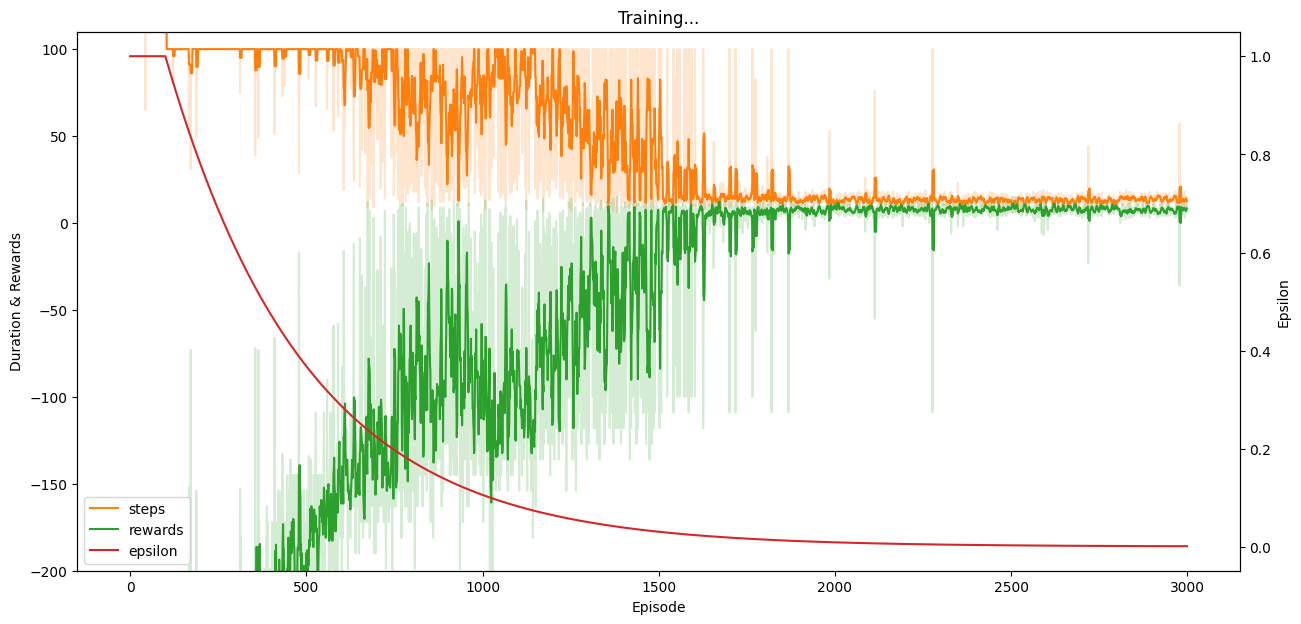

In [9]:
pt_path = train()

In [10]:
pt_path

'model_backup/pytorch_1705488841.pt'

In [12]:
class TestModel:
    def __init__(self, model_class, model_file):
        # Generate gymnasium environment variables
        self.env = gym.make("Taxi-v3", render_mode="ansi").env
        self.state, self.info = self.env.reset()
        self.stop_anim = False

        # define model related variables
        self.model_class = model_class
        self.path = model_file
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_actions = self.env.action_space.n
        self.number_of_observations = self.env.observation_space.n

        self.model = model_class(self.number_of_observations, self.n_actions).to(
            self.device
        )
        checkpoint = torch.load(self.path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.model.eval()

    def _init_test_variables(
        self, test_episodes, timestamp, fast_testing, final_frame_pause
    ):
        # test environment specific variables
        self.penalties = 0
        self.reward = 0
        self.rewards = []
        self.test_episodes = (
            test_episodes  # Number of episode to run in test environment
        )
        self.window = None
        self.done = False
        # total results variables
        self.total_epochs = 0
        self.total_penalties = 0
        # arguments related variables
        self.timestamp = timestamp
        self.fast_testing = fast_testing
        self.final_frame_pause = final_frame_pause

    def _get_action_for_state(self, state):
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            f_state = state if type(state) == int else state[0]
            predicted = self.model(torch.tensor([f_state], device=self.device))
            action = predicted.max(1)[1]
        return action.item()

    def test(
        self, test_episodes=1, timestamp=0.2, fast_testing=False, final_frame_pause=0
    ):
        self._init_test_variables(
            test_episodes, timestamp, fast_testing, final_frame_pause
        )

        for i in range(self.test_episodes):
            state = self.env.reset()[0]
            episode_reward, epochs, self.penalties, self.reward = 0, 0, 0, 0
            self.done = False

            while not self.done:
                action = self._get_action_for_state(state)
                state, self.reward, self.done, truncated, info = self.env.step(action)
                episode_reward += self.reward
                if self.reward == -10:
                    self.penalties += 1
                epochs += 1

                self.display_test(state, action, episode_reward, i)
                if epochs > 25:
                    break

            self.total_penalties += self.penalties
            self.rewards.append(episode_reward)
            self.total_epochs += epochs
        self.print_results_console()
        

    def print_results_file(self):
        results = open("results/test_results.txt", "a")
        results.write(
            "---------------------------------------------------------------------------------------------\n"
        )
        results.write(f"Results after {self.test_episodes} episodes:\n")
        results.write(
            f"Average timesteps per episode: {self.total_epochs / self.test_episodes}\n"
        )
        results.write(
            f"Average penalties per episode: {self.total_penalties / self.test_episodes}\n"
        )
        results.write(f"Max score: {max(self.rewards)}\n")
        results.write(f"Min score: {min(self.rewards)}\n")
        results.write(f"Average score: {np.mean(self.rewards)}\n")
        results.write(f"Standard deviation: {np.std(self.rewards)}\n")
        results.write(f"Total timesteps: {self.total_epochs}\n")
        results.write(f"Total penalties: {self.total_penalties}\n")
        results.write(f"Total time: {self.timestamp * self.total_epochs}\n")
        results.write(
            "---------------------------------------------------------------------------------------------\n"
        )
        results.close()

    def print_results_console(self):
        print("---------------------------------------------------------------------------------------------")
        print(f"Results after {self.test_episodes} episodes:")
        print(f"Average timesteps per episode: {self.total_epochs / self.test_episodes}")
        print(f"Average penalties per episode: {self.total_penalties / self.test_episodes}")
        print(f"Max score: {max(self.rewards)}")
        print(f"Min score: {min(self.rewards)}")
        print(f"Average score: {np.mean(self.rewards)}")
        print(f"Standard deviation: {np.std(self.rewards)}")
        print(f"Total timesteps: {self.total_epochs}")
        print(f"Total penalties: {self.total_penalties}")
        print(f"Total time: {self.timestamp * self.total_epochs}")
        print("---------------------------------------------------------------------------------------------")

    def display_test(self, state, action, episode_reward, i):
        system("clear")
        if not self.fast_testing:
            frame = {
                "frame": self.env.render(),
                "state": state,
                "action": action,
                "reward": self.reward,
                "episode_reward": episode_reward,
                "episode": i + 1,
            }
            if self.final_frame_pause and self.window and self.done:
                self.__print_frames(frame, 2, self.window)
            elif self.window:
                self.__print_frames(frame, self.timestamp, self.window)
            else:
                self.__print_frames(frame, self.timestamp)
        else:
            print(f"Test episode: {i+1} / {self.test_episodes}")

    def __print_frames(self, frame, timestamp, window=None):
 
        clear_output(wait=True)
        print(frame['frame'])
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print(f"Action: {frame['action']}")
        print(f"Eposide: {frame['episode']}")
        sleep(timestamp)

        sleep(timestamp)

In [13]:
def test(pt_path):
    model = TestModel(DQN, pt_path)
    model.test(test_episodes=NUMBER_OF_EPISODES_FOR_TESTING, # number of test episode to execute
               timestamp=1, # time between each frame
               fast_testing=False, # display graphical interface or print only test informations
               final_frame_pause=1) # time to wait after the last frame of each episode


In [14]:
test(pt_path)

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

State: 216
Action: 1
Reward: -1
Action: 1
Eposide: 28


KeyboardInterrupt: 

In [15]:
from IPython.display import HTML
video_url = "https://github.com/SergioArroni/RL/blob/main/img/1704401385.png"

video_html = """
<video width="640" height="360" controls>
  <source src="{}" type="video/mp4">
  Tu navegador no soporta el tag de video.
</video>
""".format(video_url)

display(HTML(video_html))